<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/03_benchmark_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combined Benchmark Selection with Regression Analysis
This model aims to select ETFs that best fit with both long-term and short-term portfolios to be used as benchmarks. The methodology uses a regression analysis to identify the relationship between the ETF and each portfolio and check the ETF with the highest R² and lowest p-value will be selected as the benchmark. 

The model will use the following steps:
1. Select an ETF that invests in the same sectors as the portfolio holdings.
2. Use regression analysis to identify the relationship between the ETF and the portfolio.
3. Select the ETF with the highest R² and lowest p-value as the benchmark.
4. Use the selected ETF as a benchmark to evaluate the performance of the portfolio.
5. Process both long-term and short-term portfolios in a single workflow.

### Step 1: Import Libraries

In [1]:
# UDFs
from py.utils import load_and_filter_data, export_to_excel
from py.regression_benchmark import find_best_benchmark_and_run_regressions

# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Excel libraries
from openpyxl import load_workbook
from openpyxl.styles import Alignment, Font
import ast

### Step 2: Define Parameters

#### Dates

In [2]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=10*365)            # 10 years ago from the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2015-06-12 to 2025-06-09
Time span: 3650 days (10.00 years)


#### Risk-free rate (T-bill, %)

In [3]:
# Load and process data
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433 
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
risk_free_rate_monthly = risk_free_rate / 12

# Display result
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")
daily_risk_free_df.head()

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.0424 -- 13 WEEK TREASURY BILL (^IRX)


,^IRX
Date,
2015-06-15,0.003
2015-06-16,0.008
2015-06-17,0.003
2015-06-18,0.003
2015-06-19,0.003


#### Report File

In [4]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-06-09.xlsx


### Step 3: Read ETF Data

In [5]:
# Load Data
sectors_df = pd.read_csv("data/fundamentals_benchmark.csv") 
sectors_df = sectors_df[["Ticker", "Name", "Sector Weightings"]]
sectors_df = sectors_df.rename(columns={"Name": "Name", "Ticker": "Symbol", "Sector Weightings": "Sectors"})

# Convert string representations of dictionaries to actual dictionaries
sectors_df['Sectors'] = sectors_df['Sectors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else {})

# Display
sectors_df.head()

,Symbol,Name,Sectors
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.124..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.117..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.020499999, 'consumer_cyclical..."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0...."
4,AGNG,Global X Aging Population ETF,"{'realestate': 0.0771, 'consumer_cyclical': 0...."


### Step 4: Process Both Portfolio Types


Processing LONG_TERM Portfolio
Portfolio tickers: ['MMC', 'AMAT', 'MRK', 'TMUS', 'APO']


,Ticker,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,...,52W Low,50 Day Avg,200 Day Avg,Short Ratio,Short % of Float,Strategy,Weight,Expected Return,Standard Deviation,Sharpe Ratio
0,MMC,2025-06-10,"Marsh & McLennan Companies, Inc.",Financial Services,Insurance Brokers,United States,https://www.marshmclennan.com,107446730752,130659778560,491821141,...,207.21,228.82,225.57,2.62,0.01,Markowitz,0.326653,0.142218,0.212942,0.667875
1,AMAT,2025-06-10,"Applied Materials, Inc.",Technology,Semiconductor Equipment & Materials,United States,https://www.appliedmaterials.com,139345756160,136179171328,799392549,...,123.74,152.89,172.10,2.58,0.02,Markowitz,0.237936,0.182796,0.412477,0.443167
2,MRK,2025-06-10,"Merck & Co., Inc.",Healthcare,Drug Manufacturers - General,United States,https://www.merck.com,204322521088,224881115136,2507088934,...,73.31,79.74,96.32,2.49,0.02,Markowitz,0.176463,0.098713,0.220880,0.446906
3,TMUS,2025-06-10,"T-Mobile US, Inc.",Communication Services,Telecom Services,United States,https://www.t-mobile.com,269249265664,379868151808,452736028,...,171.18,249.12,234.38,3.11,0.03,Markowitz,0.148118,0.117987,0.276632,0.426513
4,APO,2025-06-10,"Apollo Global Management, Inc.",Financial Services,Asset Management,United States,https://www.apollo.com/institutional/homepage,77548888064,96317194240,446479870,...,95.11,131.64,144.53,7.75,0.05,Markowitz,0.110830,0.142334,0.379288,0.375266



--- Step 5: Benchmark Sector Screening for long_term ---
Number of benchmarks after sector filtering: 326


,Symbol,Name,Sectors
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.124..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.117..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.020499999, 'consumer_cyclical..."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0...."
4,AIA,iShares Asia 50 ETF,"{'realestate': 0.0050999997, 'consumer_cyclica..."


,Symbol,Name_x,Sectors,Date,Name_y,Sector,Industry,Country,Website,Market Cap,...,Dividend Rate (%),5Y Avg Dividend Yield (%),Payout Ratio (%),Price,Analyst Rating,52W High,52W Low,50 Day Avg,200 Day Avg,Sector Weightings
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.124...",2025-06-10,AdvisorShares Dorsey Wright ADR ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,78.09,Unknown,81.17,54.57,74.78,70.56,"{""realestate"": 0.0, ""consumer_cyclical"": 0.124..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.117...",2025-06-10,Abacus FCF Leaders ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,70.01,Unknown,71.28,55.40,65.30,66.40,"{""realestate"": 0.0, ""consumer_cyclical"": 0.117..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.020499999, 'consumer_cyclical...",2025-06-10,iShares MSCI ACWI ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,126.52,Unknown,126.58,101.25,118.03,118.99,"{""realestate"": 0.020499999, ""consumer_cyclical..."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0....",2025-05-02,Aptus Drawdown Managed Equity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,44.46,Unknown,48.56,39.85,44.34,45.90,"{""realestate"": 0.0222, ""consumer_cyclical"": 0...."
4,AIA,iShares Asia 50 ETF,"{'realestate': 0.0050999997, 'consumer_cyclica...",2025-06-10,iShares Asia 50 ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,80.10,Unknown,80.16,59.33,72.21,71.33,"{""realestate"": 0.0050999997, ""consumer_cyclica..."


Portfolio Weighted Average P/E: 21.92
P/E Filter Range: 17.54 - 26.31
Number of benchmarks after P/E filtering: 140


,Symbol,Name_x,Sectors,Date,Name_y,Sector,Industry,Country,Website,Market Cap,...,Dividend Rate (%),5Y Avg Dividend Yield (%),Payout Ratio (%),Price,Analyst Rating,52W High,52W Low,50 Day Avg,200 Day Avg,Sector Weightings
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.020499999, 'consumer_cyclical...",2025-06-10,iShares MSCI ACWI ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,126.52,Unknown,126.58,101.25,118.03,118.99,"{""realestate"": 0.020499999, ""consumer_cyclical..."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0....",2025-05-02,Aptus Drawdown Managed Equity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,44.46,Unknown,48.56,39.85,44.34,45.90,"{""realestate"": 0.0222, ""consumer_cyclical"": 0...."
6,AOA,iShares Core 80/20 Aggressive Allocation ETF,"{'realestate': 0.0279, 'consumer_cyclical': 0....",2025-05-02,iShares Core 80/20 Aggressive Allocation ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,77.74,Unknown,80.20,68.45,76.13,77.15,"{""realestate"": 0.0279, ""consumer_cyclical"": 0...."
7,AOK,iShares Core 30/70 Conservative Allocation ETF,"{'realestate': 0.027, 'consumer_cyclical': 0.1...",2025-06-10,iShares Core 30/70 Conservative Allocation ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,38.38,Unknown,38.77,35.79,37.59,37.85,"{""realestate"": 0.027, ""consumer_cyclical"": 0.1..."
8,AOM,iShares Core 40/60 Moderate Allocation ETF,"{'realestate': 0.027, 'consumer_cyclical': 0.1...",2025-06-10,iShares Core 40/60 Moderate Allocation ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,45.16,Unknown,45.31,41.20,43.83,44.15,"{""realestate"": 0.027, ""consumer_cyclical"": 0.1..."



--- Step 6: Import Quotes for long_term ---
Found 133 of 140 tickers in data/daily_benchmark_quotes.csv
Missing tickers: ['AOA', 'EMQQ', 'IJK', 'IVOG', 'MDYG', 'MOAT', 'UPGD']
Found 5 of 5 tickers in data/monthly_stock_quotes.csv
Missing tickers: []

--- Step 7: Prepare Data for long_term ---
Dropping 45 columns with missing values: ['ADME', 'BAPR', 'BBUS', 'BJAN', 'BJUL', 'BOCT', 'CEFS', 'DEUS', 'DIVB', 'DIVO', 'DYNF', 'EQIN', 'ESGG', 'ETHO', 'FCEF', 'FLIN', 'FLQM', 'FVAL', 'GVIP', 'HTUS', 'IUS', 'JDIV', 'JMOM', 'JPME', 'JQUA', 'JSMD', 'MAGA', 'MFUS', 'NACP', 'ONEO', 'PBUS', 'PJUL', 'POCT', 'PSC', 'QARP', 'QLC', 'QMOM', 'RFDA', 'SPXV', 'USMF', 'USSG', 'VFMO', 'VIGI', 'WOMN', 'YLDE']

--- Step 8: Calculate Returns for long_term ---

--- Step 10: Find Best Benchmark for long_term ---
Best benchmark for long_term: YYY


,Equity,Benchmark,intercept (alpha),slope (beta),correlation,r_squared,p_value_slope,p_value_intercept
0,AMAT,YYY,0.016200,1.535901,0.656366,0.430816,5.337848e-16,0.021022
1,APO,YYY,0.015609,1.608723,0.691495,0.478165,3.154495e-18,0.019539
2,MMC,YYY,0.008896,0.858830,0.686936,0.471882,6.394176e-18,0.013954
3,MRK,YYY,0.001767,0.331879,0.247392,0.061203,6.676833e-03,0.729494
4,TMUS,YYY,0.011355,0.510230,0.371315,0.137874,3.218241e-05,0.025119


,benchmark,avg_slope,slope_std,avg_p_value_intercept,avg_p_value_slope,avg_r_squared,beta_quality,score
82,YYY,0.969113,0.521374,0.161825,0.001342,0.315988,0.969113,0.755847
80,XRLV,1.003125,0.380549,0.293555,0.000004,0.329391,0.996875,0.751411
34,ILCV,0.998405,0.451695,0.286190,0.000006,0.346754,0.998405,0.749563
77,VTV,0.986318,0.431271,0.296978,0.000004,0.341082,0.986318,0.745820
9,DTD,1.000932,0.445210,0.310819,0.000008,0.344876,0.999068,0.745011
46,MGV,1.017275,0.428204,0.305636,0.000002,0.339969,0.982725,0.743447
35,IMTM,0.985722,0.494607,0.235312,0.000088,0.294647,0.985722,0.742808
76,VT,1.005264,0.538273,0.285993,0.000171,0.352414,0.994736,0.742213
79,VYM,1.008856,0.445362,0.300074,0.000006,0.326494,0.991144,0.741885
40,IVE,0.951988,0.436127,0.291094,0.000012,0.346157,0.951988,0.740671



--- Step 11: Plot Results for long_term ---
📈 BENCHMARK REGRESSION ANALYSIS: YYY
🔍 AMAT: β=1.5359, R²=0.4308, p=0.0000, Weight=23.8%
🔍 APO: β=1.6087, R²=0.4782, p=0.0000, Weight=11.1%
🔍 MMC: β=0.8588, R²=0.4719, p=0.0000, Weight=32.7%
🔍 MRK: β=0.3319, R²=0.0612, p=0.0067, Weight=17.6%
🔍 TMUS: β=0.5102, R²=0.1379, p=0.0000, Weight=14.8%


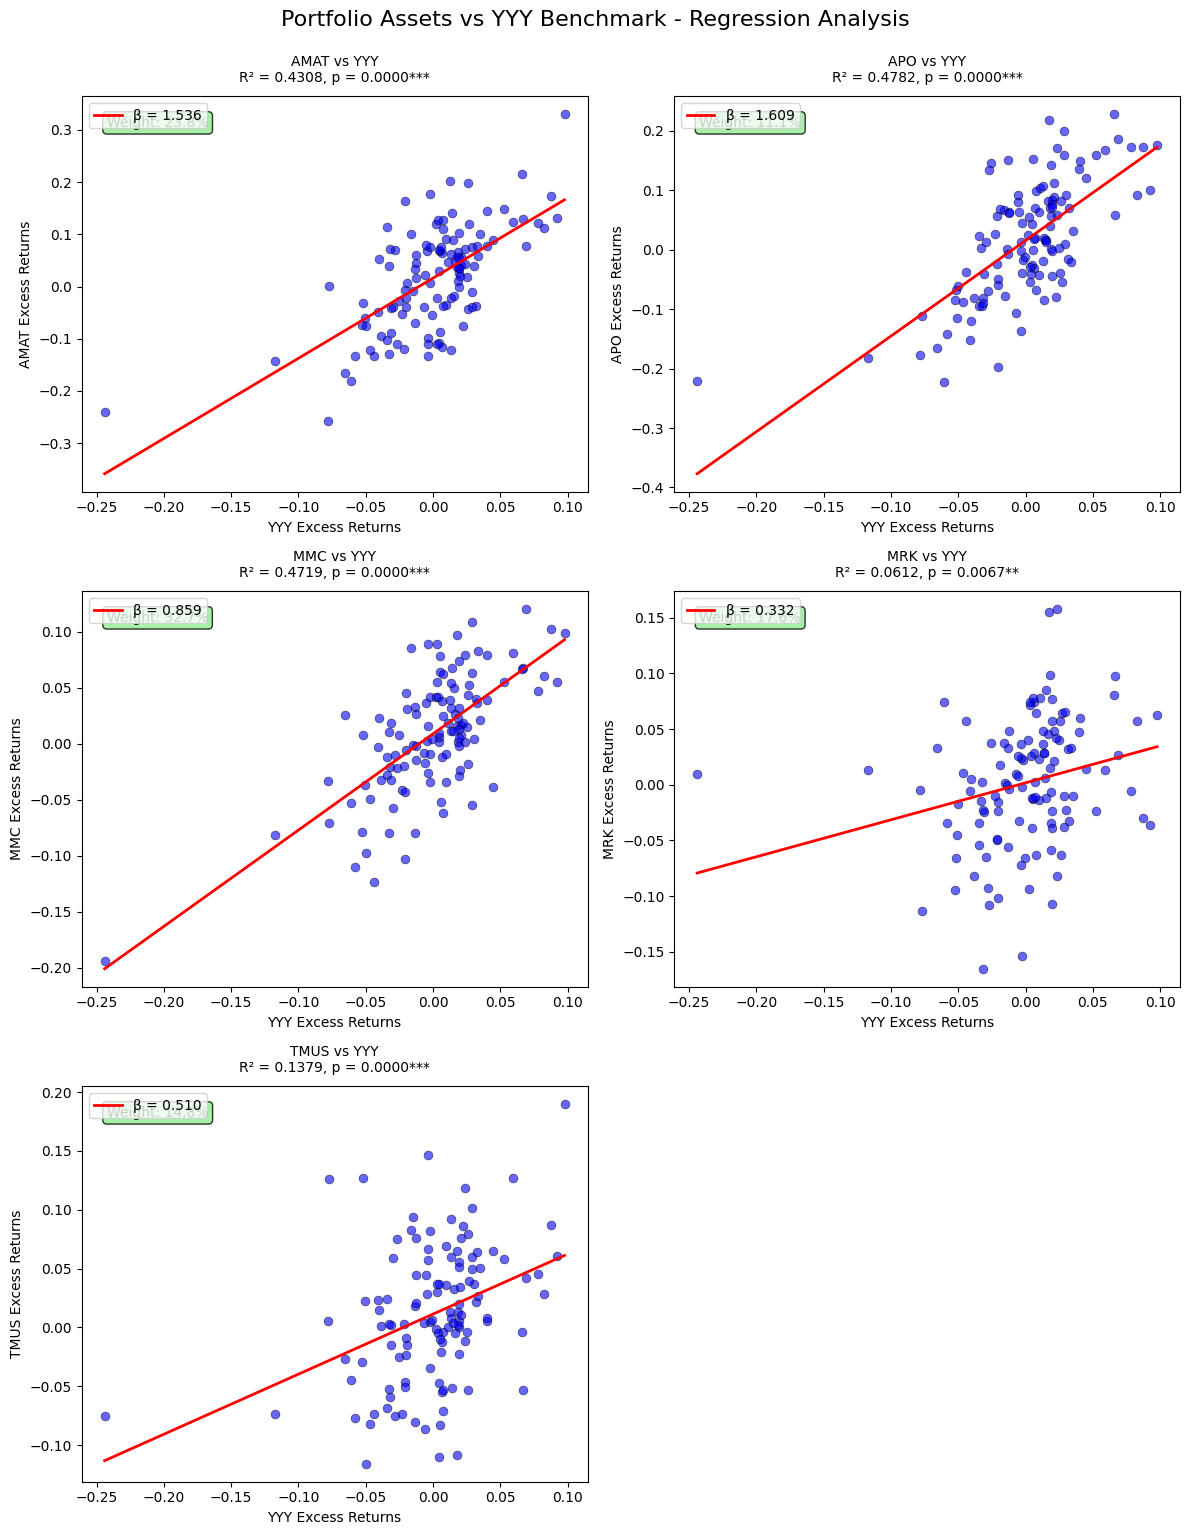


📊 BENCHMARK REGRESSION SUMMARY: YYY


,Ticker,Beta,Alpha,R_Squared,Correlation,P_Value,Portfolio_Weight,N_Observations,Significance
0,AMAT,1.5359,0.0162,0.4308,0.6564,0.0000,0.2379,119,***
1,APO,1.6087,0.0156,0.4782,0.6915,0.0000,0.1108,119,***
2,MMC,0.8588,0.0089,0.4719,0.6869,0.0000,0.3267,119,***
3,MRK,0.3319,0.0018,0.0612,0.2474,0.0067,0.1765,119,**
4,TMUS,0.5102,0.0114,0.1379,0.3713,0.0000,0.1481,119,***



📈 PORTFOLIO STATISTICS: Weighted β=0.9584, Weighted R²=0.3409
  • Significant relationships (p<0.05): 5/5
Portfolio sectors: {'Technology', 'Communication Services', 'Healthcare', 'Financial Services'}
Benchmark sectors: {'Healthcare', 'Technology', 'Consumer Defensive', 'Basic Materials', 'Financial Services', 'Consumer Cyclical', 'Energy', 'Industrials', 'Communication Services', 'Utilities', 'Realestate'}


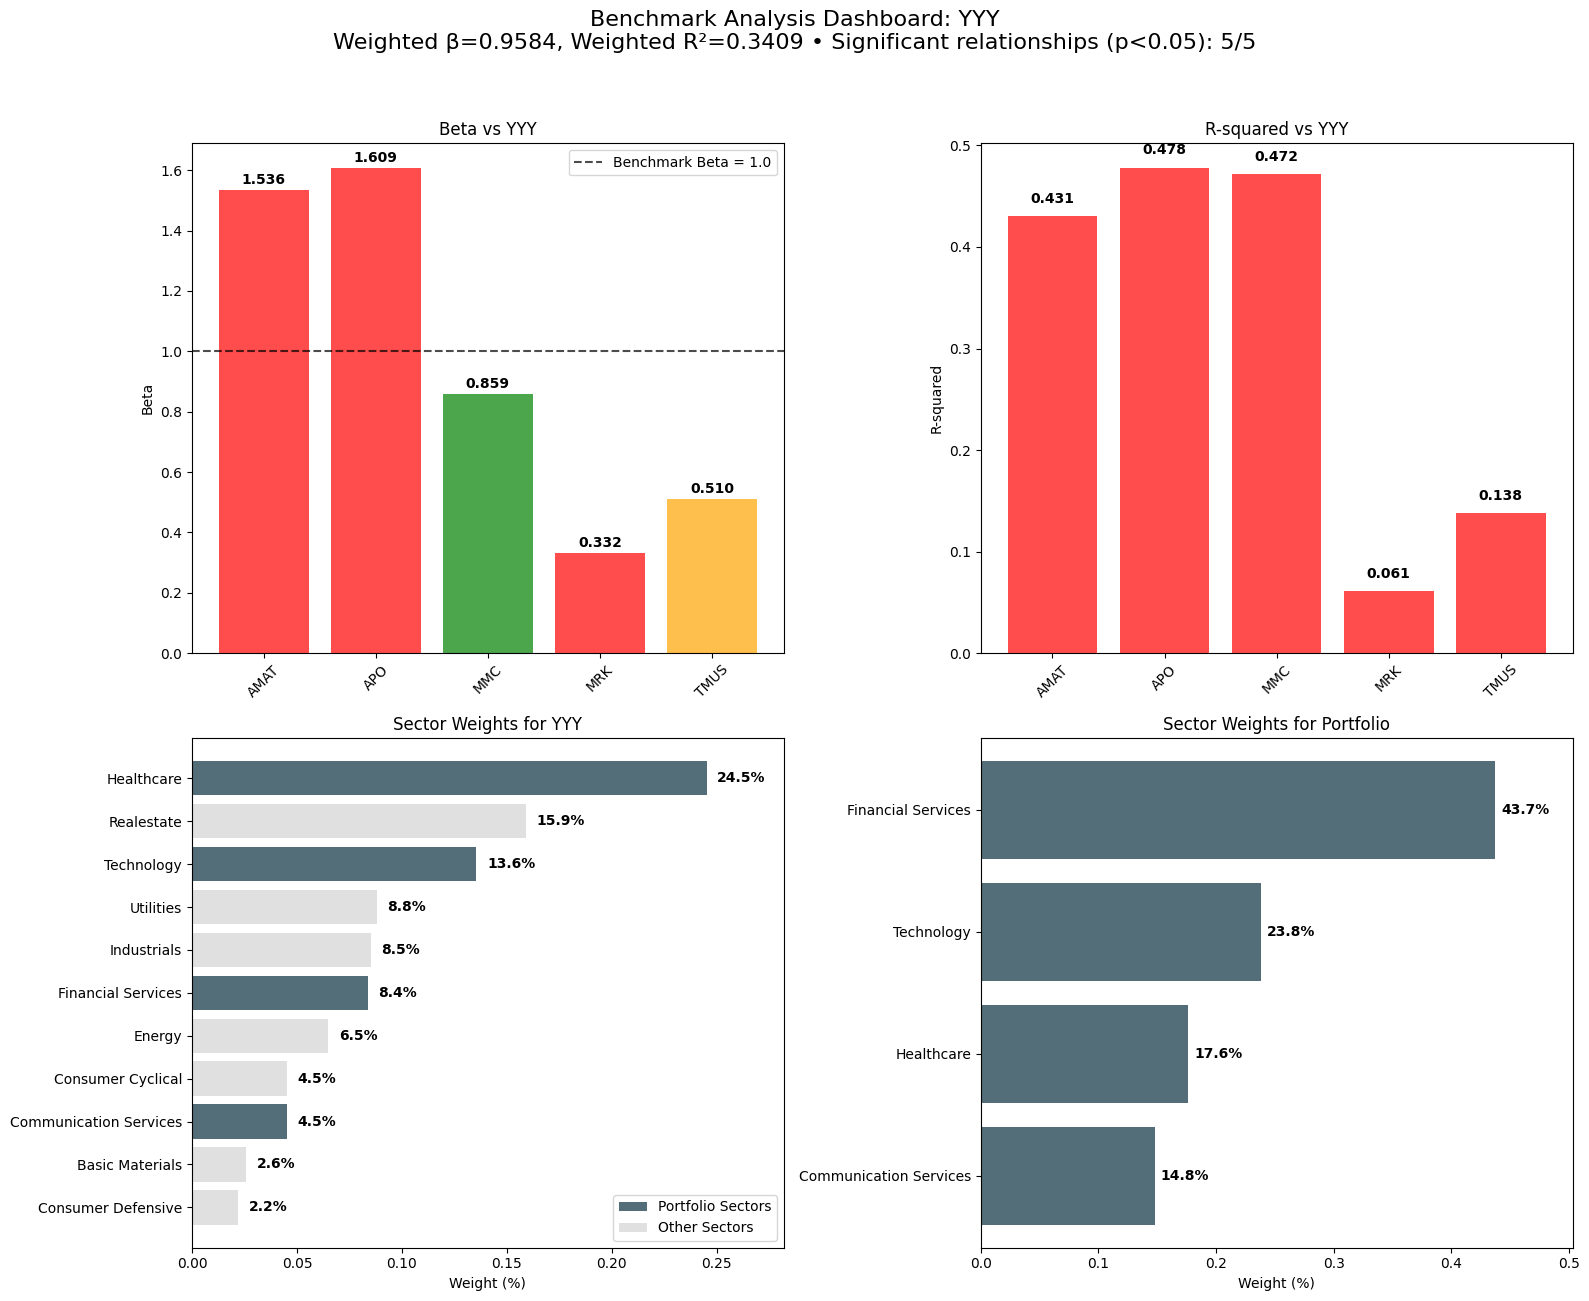

Completed processing for long_term: YYY

Processing SHORT_TERM Portfolio
Portfolio tickers: ['GRMN', 'MSFT']


,Ticker,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,...,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score,Weight
0,GRMN,2025-06-10,Garmin Ltd.,Technology,Scientific & Technical Instruments,Switzerland,https://www.garmin.com,40431685632,37608386560,174794910,...,60,100,6,0.6524,0.0000,0.6667,0.3048,0.513,0.5687,0.5
1,MSFT,2025-06-10,Microsoft Corporation,Technology,Software - Infrastructure,United States,https://www.microsoft.com,3497679126528,3539136151552,7422063978,...,75,130,46,0.6189,0.0435,0.7174,0.2379,0.513,0.5687,0.5



--- Step 5: Benchmark Sector Screening for short_term ---
Number of benchmarks after sector filtering: 391


,Symbol,Name,Sectors
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.124..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.117..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.020499999, 'consumer_cyclical..."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0...."
4,AIA,iShares Asia 50 ETF,"{'realestate': 0.0050999997, 'consumer_cyclica..."


,Symbol,Name_x,Sectors,Date,Name_y,Sector,Industry,Country,Website,Market Cap,...,Dividend Rate (%),5Y Avg Dividend Yield (%),Payout Ratio (%),Price,Analyst Rating,52W High,52W Low,50 Day Avg,200 Day Avg,Sector Weightings
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.124...",2025-06-10,AdvisorShares Dorsey Wright ADR ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,78.09,Unknown,81.17,54.57,74.78,70.56,"{""realestate"": 0.0, ""consumer_cyclical"": 0.124..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.117...",2025-06-10,Abacus FCF Leaders ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,70.01,Unknown,71.28,55.40,65.30,66.40,"{""realestate"": 0.0, ""consumer_cyclical"": 0.117..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.020499999, 'consumer_cyclical...",2025-06-10,iShares MSCI ACWI ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,126.52,Unknown,126.58,101.25,118.03,118.99,"{""realestate"": 0.020499999, ""consumer_cyclical..."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0....",2025-05-02,Aptus Drawdown Managed Equity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,44.46,Unknown,48.56,39.85,44.34,45.90,"{""realestate"": 0.0222, ""consumer_cyclical"": 0...."
4,AIA,iShares Asia 50 ETF,"{'realestate': 0.0050999997, 'consumer_cyclica...",2025-06-10,iShares Asia 50 ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,80.10,Unknown,80.16,59.33,72.21,71.33,"{""realestate"": 0.0050999997, ""consumer_cyclica..."


Portfolio Weighted Average P/E: 32.02
P/E Filter Range: 25.62 - 38.42
Number of benchmarks after P/E filtering: 80


,Symbol,Name_x,Sectors,Date,Name_y,Sector,Industry,Country,Website,Market Cap,...,Dividend Rate (%),5Y Avg Dividend Yield (%),Payout Ratio (%),Price,Analyst Rating,52W High,52W Low,50 Day Avg,200 Day Avg,Sector Weightings
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.117...",2025-06-10,Abacus FCF Leaders ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,70.01,Unknown,71.28,55.40,65.30,66.40,"{""realestate"": 0.0, ""consumer_cyclical"": 0.117..."
5,AIQ,Global X Artificial Intelligence & Technology ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.102...",2025-06-02,Global X Artificial Intelligence & Technology ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,40.30,Unknown,42.78,30.60,37.32,37.94,"{""realestate"": 0.0, ""consumer_cyclical"": 0.102..."
10,ARKW,ARK Next Generation Internet ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.166...",2025-06-10,ARK Next Generation Internet ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,131.35,Unknown,132.01,64.00,106.47,102.14,"{""realestate"": 0.0, ""consumer_cyclical"": 0.166..."
25,CIBR,First Trust NASDAQ Cybersecurity ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.0, ...",2025-06-10,First Trust NASDAQ Cybersecurity ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,72.60,Unknown,73.82,50.52,66.98,64.26,"{""realestate"": 0.0, ""consumer_cyclical"": 0.0, ..."
51,DRSK,Aptus Defined Risk ETF,"{'realestate': 0.0227, 'consumer_cyclical': 0....",2025-06-10,Aptus Defined Risk ETF,Unknown,Unknown,Unknown,Unknown,0.0,...,0.0,0.0,0.0,28.25,Unknown,29.24,26.42,27.50,27.86,"{""realestate"": 0.0227, ""consumer_cyclical"": 0...."



--- Step 6: Import Quotes for short_term ---
Found 78 of 80 tickers in data/daily_benchmark_quotes.csv
Missing tickers: ['PTNQ', 'XSD']
Found 2 of 2 tickers in data/monthly_stock_quotes.csv
Missing tickers: []

--- Step 7: Prepare Data for short_term ---
Dropping 18 columns with missing values: ['ABFL', 'AIQ', 'CIBR', 'DRSK', 'ESPO', 'FDMO', 'GVIP', 'IETC', 'JMOM', 'NULG', 'QGRO', 'QMOM', 'SPMO', 'SPYX', 'TMFC', 'USMC', 'USSG', 'XLG']

--- Step 8: Calculate Returns for short_term ---

--- Step 10: Find Best Benchmark for short_term ---
Best benchmark for short_term: DSI


,Equity,Benchmark,intercept (alpha),slope (beta),correlation,r_squared,p_value_slope,p_value_intercept
0,GRMN,DSI,0.006243,0.941914,0.616647,0.380254,8.234481e-14,0.231291
1,MSFT,DSI,0.010853,0.958965,0.754666,0.569521,3.737893e-23,0.003131


,benchmark,avg_slope,slope_std,avg_p_value_intercept,avg_p_value_slope,avg_r_squared,beta_quality,score
1,DSI,0.950439,0.008526,0.117211,4.117240e-14,0.474887,0.950439,0.859932
22,MGC,0.984416,0.007817,0.156067,4.133555e-14,0.473666,0.984416,0.858852
16,IWL,0.986088,0.010119,0.158946,4.237249e-14,0.475987,0.986088,0.858622
25,OEF,0.987467,0.029585,0.163602,1.131785e-13,0.485829,0.987467,0.856192
42,SPY,0.973226,0.017427,0.134535,1.504727e-14,0.458097,0.973226,0.855932
55,VV,0.963544,0.014567,0.131701,1.495486e-14,0.461121,0.963544,0.855721
12,IVV,0.972226,0.016212,0.136139,1.659318e-14,0.458212,0.972226,0.855669
51,VOO,0.972606,0.016191,0.136809,1.697363e-14,0.457967,0.972606,0.855566
34,QUAL,0.956582,0.028816,0.115050,3.358078e-15,0.462935,0.956582,0.855292
36,SCHX,0.962506,0.023386,0.129839,8.566652e-15,0.458127,0.962506,0.853589



--- Step 11: Plot Results for short_term ---
📈 BENCHMARK REGRESSION ANALYSIS: DSI
🔍 GRMN: β=0.9419, R²=0.3803, p=0.0000, Weight=50.0%
🔍 MSFT: β=0.9590, R²=0.5695, p=0.0000, Weight=50.0%


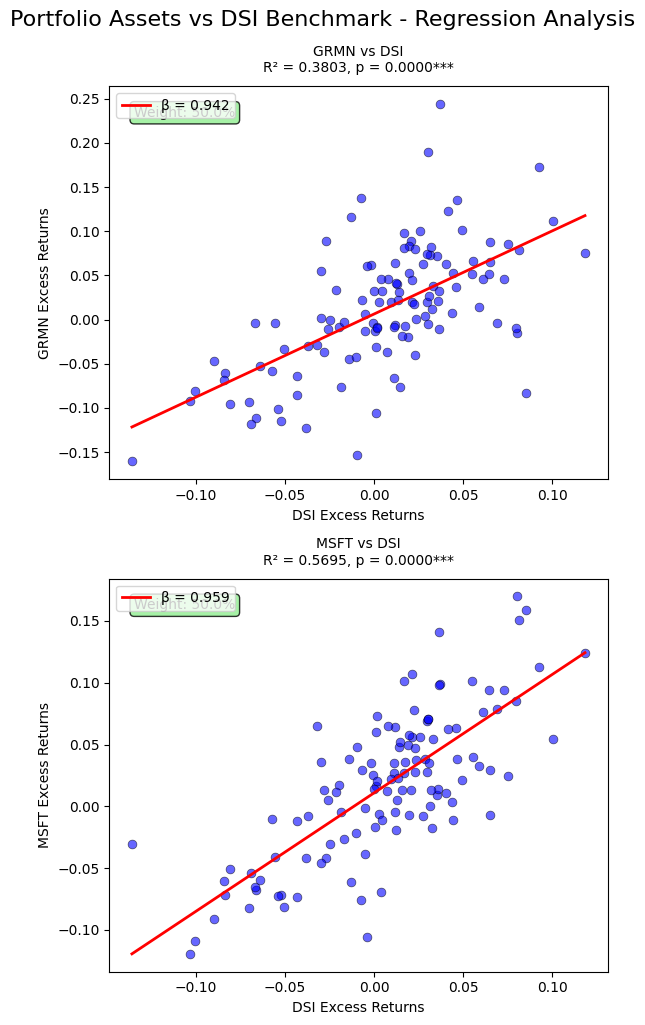


📊 BENCHMARK REGRESSION SUMMARY: DSI


,Ticker,Beta,Alpha,R_Squared,Correlation,P_Value,Portfolio_Weight,N_Observations,Significance
0,GRMN,0.9419,0.0062,0.3803,0.6166,0.0,0.5,119,***
1,MSFT,0.9590,0.0109,0.5695,0.7547,0.0,0.5,119,***



📈 PORTFOLIO STATISTICS: Weighted β=0.9504, Weighted R²=0.4749
  • Significant relationships (p<0.05): 2/2
Portfolio sectors: {'Technology'}
Benchmark sectors: {'Healthcare', 'Technology', 'Consumer Defensive', 'Realestate', 'Basic Materials', 'Financial Services', 'Energy', 'Industrials', 'Communication Services', 'Utilities', 'Consumer Cyclical'}


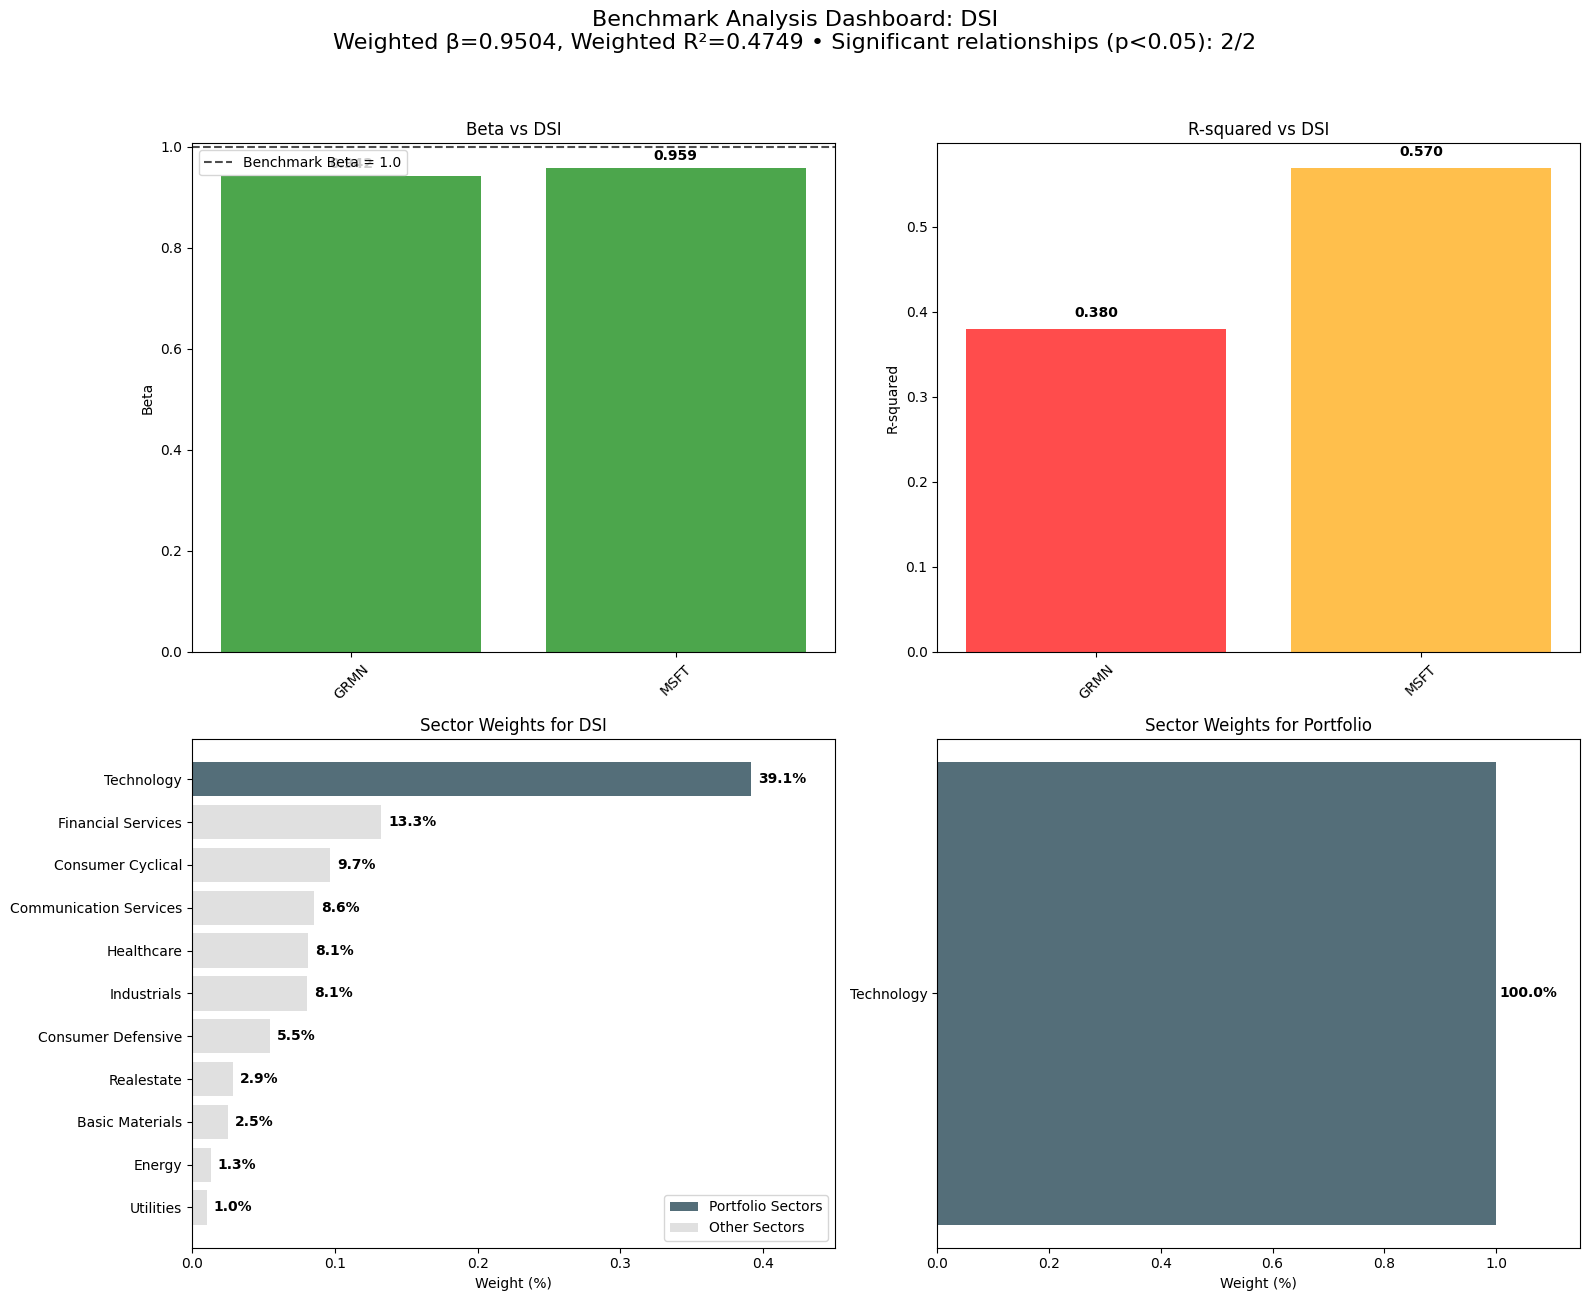

Completed processing for short_term: DSI


In [6]:
# Define portfolio types to process
portfolio_types = ["long_term", "short_term"]
results = {}

# Process each portfolio type
for portfolio_type in portfolio_types:
    print(f"\n{'='*60}")
    print(f"Processing {portfolio_type.upper()} Portfolio")
    print(f"{'='*60}")
    
    # Read Portfolio Data
    portfolio_df = pd.read_excel(output_file, sheet_name=portfolio_type)   
    portfolio_tickers = portfolio_df["Ticker"].tolist()
    
    # Handle different column naming conventions
    pe_column = "P/E (trailing)" if "P/E (trailing)" in portfolio_df.columns else "P/E (Trailing)"
    portfolio_df[pe_column] = pd.to_numeric(portfolio_df[pe_column], errors="coerce")
    
    print(f"Portfolio tickers: {portfolio_tickers}")
    display(portfolio_df.head())
    
    # Benchmark Sector Screening
    print(f"\n--- Step 5: Benchmark Sector Screening for {portfolio_type} ---")
    
    # Sort portfolio sectors by weight (descending)
    portfolio_sector_weights = (
        portfolio_df.groupby('Sector')['Weight'].sum()
        .sort_values(ascending=False)
    )
    ordered_portfolio_sectors = [sector.strip() for sector in portfolio_sector_weights.index]
    normalized_ordered_portfolio_sectors = [sector.strip().lower().replace(" ", "_") for sector in ordered_portfolio_sectors]
    
    # Filter ETFs by portfolio sectors
    filtered_sectors_df = sectors_df[
        sectors_df['Sectors'].apply(
            lambda sector_dict: isinstance(sector_dict, dict) and all(
                sector in sector_dict and sector_dict[sector] > 0 
                for sector in normalized_ordered_portfolio_sectors
            )
        )
    ].reset_index(drop=True)
    
    tickers = filtered_sectors_df["Symbol"].tolist()
    print(f"Number of benchmarks after sector filtering: {len(tickers)}")
    display(filtered_sectors_df.head())
    
    # Import ETF Fundamental Data
    fundamentals_df = pd.read_csv("data/fundamentals_benchmark.csv",index_col="Ticker").query("Ticker in @tickers")
    fundamentals_df.index.name = "Symbol"
    fundamentals_df = fundamentals_df.reset_index()
    
    # Merge sector and fundamental data
    merged_df = pd.merge(filtered_sectors_df, fundamentals_df, on='Symbol', how='inner').dropna(how='all', axis=1)
    display(merged_df.head())
    
    # Filter by P/E ratio similar to portfolio
    weighted_average_pe = (portfolio_df["Weight"] * portfolio_df[pe_column]).sum()
    lower_bound = weighted_average_pe * 0.8  # 20% below
    upper_bound = weighted_average_pe * 1.2  # 20% above
    
    filtered_merged_df = merged_df[
        (merged_df["P/E (trailing)"] >= lower_bound) & 
        (merged_df["P/E (trailing)"] <= upper_bound)
    ]
    
    filtered_sectors_df = filtered_merged_df.copy().dropna(how='all')
    tickers = filtered_sectors_df["Symbol"].tolist()
    
    print(f"Portfolio Weighted Average P/E: {weighted_average_pe:.2f}")
    print(f"P/E Filter Range: {lower_bound:.2f} - {upper_bound:.2f}")
    print(f"Number of benchmarks after P/E filtering: {len(filtered_merged_df)}")
    display(filtered_sectors_df.head())
    
    # Import Quotes
    print(f"\n--- Step 6: Import Quotes for {portfolio_type} ---")
    
    # Benchmark quotes
    benchmark_prices_daily_df = load_and_filter_data('data/daily_benchmark_quotes.csv', tickers, start_date, end_date)
    
    # Portfolio quotes
    stock_prices_monthly_df = load_and_filter_data('data/monthly_stock_quotes.csv', portfolio_tickers, start_date, end_date)
    
    # Clean benchmark data
    print(f"\n--- Step 7: Prepare Data for {portfolio_type} ---")
    
    # Remove tickers with missing data in first/last 50 rows
    first_50_nulls = benchmark_prices_daily_df.head(50).isnull().any()
    last_50_nulls = benchmark_prices_daily_df.tail(50).isnull().any()
    columns_to_drop = first_50_nulls | last_50_nulls
    bad_columns = columns_to_drop[columns_to_drop].index.tolist()
    
    print(f"Dropping {len(bad_columns)} columns with missing values: {bad_columns}")
    benchmark_prices_daily_df = benchmark_prices_daily_df.loc[:, ~columns_to_drop]
    
    # Convert to monthly data
    benchmark_prices_monthly_df = (benchmark_prices_daily_df.set_index(pd.to_datetime(benchmark_prices_daily_df.pop('Date')))
          if 'Date' in benchmark_prices_daily_df.columns else benchmark_prices_daily_df.copy())
    benchmark_prices_monthly_df.index = pd.to_datetime(benchmark_prices_monthly_df.index)              
    benchmark_prices_monthly_df = (benchmark_prices_monthly_df.resample('MS').last()
       .reset_index()
       .rename(columns={'index': 'Date'}))
    benchmark_prices_monthly_df.set_index('Date', inplace=True)
    
    # Calculate Returns
    print(f"\n--- Step 8: Calculate Returns for {portfolio_type} ---")
    
    # Log returns
    benchmark_log_returns_df = np.log(benchmark_prices_monthly_df / benchmark_prices_monthly_df.shift(1))
    benchmark_log_returns_df = benchmark_log_returns_df.dropna().sort_index(axis=0, ascending=True).sort_index(axis=1, ascending=True)
    
    stock_log_returns_df = np.log(stock_prices_monthly_df / stock_prices_monthly_df.shift(1))
    stock_log_returns_df = stock_log_returns_df.dropna().sort_index(axis=0, ascending=True).sort_index(axis=1, ascending=True)
    
    # Excess returns
    benchmark_excess_returns_df = benchmark_log_returns_df - risk_free_rate_monthly
    stock_excess_returns_df = stock_log_returns_df - risk_free_rate_monthly
    
    # Find Best Benchmark
    print(f"\n--- Step 10: Find Best Benchmark for {portfolio_type} ---")
    
    best_benchmark, benchmark_stats_df, best_benchmarks_df = find_best_benchmark_and_run_regressions(
        benchmark_excess_returns_df, 
        stock_excess_returns_df
    )
    
    print(f"Best benchmark for {portfolio_type}: {best_benchmark}")
    display(best_benchmarks_df)
    display(benchmark_stats_df.sort_values(by="score", ascending=False).head(10))
    
    # Plot Results
    print(f"\n--- Step 11: Plot Results for {portfolio_type} ---")
    
    from py.regression_benchmark import analyze_benchmark_regression, plot_benchmark_analysis
    
    benchmark_regression_results = analyze_benchmark_regression(benchmark_excess_returns_df, stock_excess_returns_df, best_benchmark, portfolio_df)
    
    best_benchmark_sectors = filtered_sectors_df[filtered_sectors_df["Symbol"] == best_benchmarks_df['Benchmark'].unique()[0]]
    best_benchmark_sectors = best_benchmark_sectors[["Symbol", "Name_x", "Sectors"]] 
    best_benchmark_sectors = best_benchmark_sectors.rename(columns={"Name_x": "Name"})
    
    # Set cols based on portfolio type for better visualization
    cols = 2 if portfolio_type == "long_term" else 1
    
    benchmark_regression_summary = plot_benchmark_analysis(
        regression_results=benchmark_regression_results, 
        best_benchmark=best_benchmark, 
        cols=cols, 
        benchmark_sectors_df=best_benchmark_sectors,
        portfolio_df=portfolio_df 
    )
    
    # Store results for export
    first_column = best_benchmarks_df.columns[0]
    best_benchmarks_df.set_index(first_column, drop=True, inplace=True)
    best_benchmark = best_benchmarks_df['Benchmark'].unique()[0]
    
    results[portfolio_type] = {
        'best_benchmarks_df': best_benchmarks_df,
        'benchmark_prices_daily_df': benchmark_prices_daily_df[[best_benchmark]],
        'benchmark_prices_monthly_df': benchmark_prices_monthly_df[[best_benchmark]],
        'best_benchmark': best_benchmark
    }
    
    print(f"Completed processing for {portfolio_type}: {best_benchmark}")

### Step 12: Export Combined Results to Excel

In [7]:
# Prepare export data for both portfolio types
export_data = {}

for portfolio_type in portfolio_types:
    result = results[portfolio_type]
    export_data[f'benchmark_{portfolio_type}'] = result['best_benchmarks_df']

# Add daily and monthly quotes for both benchmarks
# Note: We'll combine the quotes if they're the same benchmark, otherwise keep separate
long_term_benchmark = results['long_term']['best_benchmark']
short_term_benchmark = results['short_term']['best_benchmark']

if long_term_benchmark == short_term_benchmark:
    # Same benchmark for both - use single columns
    export_data['daily_quotes'] = results['long_term']['benchmark_prices_daily_df']
    export_data['monthly_quotes'] = results['long_term']['benchmark_prices_monthly_df']
else:
    # Different benchmarks - combine into single dataframes
    daily_combined = pd.concat([
        results['long_term']['benchmark_prices_daily_df'], 
        results['short_term']['benchmark_prices_daily_df']
    ], axis=1)
    monthly_combined = pd.concat([
        results['long_term']['benchmark_prices_monthly_df'], 
        results['short_term']['benchmark_prices_monthly_df']
    ], axis=1)
    
    export_data['daily_quotes'] = daily_combined
    export_data['monthly_quotes'] = monthly_combined

# Export to Excel
export_to_excel(output_file, export_data)

print("\n" + "="*60)
print("SUMMARY OF RESULTS")
print("="*60)
print(f"Long-term portfolio benchmark: {results['long_term']['best_benchmark']}")
print(f"Short-term portfolio benchmark: {results['short_term']['best_benchmark']}")
print(f"Results exported to: {output_file}")
print("="*60)

Updated sheet 'benchmark_long_term'
Updated sheet 'benchmark_short_term'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-09.xlsx

SUMMARY OF RESULTS
Long-term portfolio benchmark: YYY
Short-term portfolio benchmark: DSI
Results exported to: portfolios/portfolio-2025-06-09.xlsx
